# Bayesian inference

## Imports

In [4]:
%config InlineBackend.figure_format="retina"

In [5]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc3 as pm
from numpy.typing import NDArray
from scipy import stats

## Bayesian modeling


**quantities parameters** are unkown quantities
descibed using probability distributions.
Baye's theorem is used
to update the values of the parameters.

3 steps of Bayesian modeling:

1. Give some data
    and some assumptions on how it's generated.
    Design a model.
2. Use Baye's theorem
    to condition the model on the available data.
    **Inference** produces a posterior distribution.
3. Criticize the model,
    or compare several models.

## Bayesian inference

Baye's theorem allows us to estimate the parameter $\theta$
given observed data $Y$.

$$
\underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text{posterior}} = \frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{likelihood}}\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}}{\underbrace{{p(\boldsymbol{Y})}}_{\text{marginal likelihood}}}
$$

**Likelihood** function
links the observed data
with the unknown parameters.
**Prior** represents uncertainty about parameters
before observing data $Y$.
The product of the two
is the **posterior** distribution—the
joint distribution over all parameters in the model
conditioned on the observed data.

Calculations are done in log scale.
Because the location of the maxima and minima is preserved,
but computations are numerically more stable.

Finding the marginal likelihood can be tricky,
so we just look at it proportionally.

$$
\underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text{posterior}} \propto \overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{likelihood}}\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}
$$

Expectations

$$
J = \int f(\boldsymbol{\theta}) \; p(\boldsymbol{\theta} \mid \boldsymbol{Y}) \; d\boldsymbol{\theta}
$$

**Prior predictive distribution**
is the expected distribution of the data
according to the model
before actually seeing any observed data $\boldsymbol{Y}^\ast$.

$$
p(\boldsymbol{Y}^\ast) =  \int_{\boldsymbol{\Theta}} p(\boldsymbol{Y^\ast} \mid \boldsymbol{\theta}) \; p(\boldsymbol{\theta}) \; d\boldsymbol{\theta}
$$

It is a way to evaluate and calibrate our models using domain knowledge.
Eg. is it ok for a model of human height to output -1.5?

**Posterior predictive distribution**
is the distribution of the expected future data $\tilde{\boldsymbol{Y}}$
according to the posterior,
which is a consequence of the model and observed data.
It's the data the model expects to see after seeing the dataset $\boldsymbol{Y}$.

$$
p(\tilde{\boldsymbol{Y}} \mid \boldsymbol{Y}) = \int_{\boldsymbol{\Theta}} p(\tilde{\boldsymbol{Y}} \mid \boldsymbol{\theta}) \, p(\boldsymbol{\theta} \mid \boldsymbol{Y}) \, d\boldsymbol{\theta}
$$

Posteriors are generated from data and model,
so they do not comment on non-observed data.

## A DIY sampler

**Markov chain Monte Carlo (MCMC)**
methods approximate the posterior distribution
using samples.
The samples are generated by accepting or rejecting samples
from a different proposal distribution.

One algorithm is Metropolis-Hastings,
whichi is not modern,
but simple:

1. Initialize the value of the parameter $\boldsymbol{X}$ at $x_i$
2. Use a proposal distribution $q(x_{i + 1} \mid x_i)$ to generate a new value $x_{i + 1}$ from the old one $x_i$.
3. Compute the probability of accepting the new value as:

    $$
    p_a (x_{i + 1} \mid x_i) = \min \left (1, \frac{p(x_{i + 1}) \;
    q(x_i \mid x_{i + 1})} {p(x_i) \; q (x_{i + 1} \mid x_i)} \right)
    $$
4. If $p_a > R$ where $R \sim \mathcal{U}(0, 1)$, save the new value, otherwise save the old one.
5. Iterate 2 to 4 until a sufficiently large sample of values has been generated

Algorithm will always accept moving from a low probability region to a higher one,
and will probabalistically accept moving from a high to low propability region.
It does not seaerch for the maximum probability,
but aims to explore the distribution.

Example:

$$
\begin{split}
    \theta \sim &\; \text{Beta}(\alpha, \beta) \\
    Y \sim &\; \text{Bin}(n=1, p=\theta)
\end{split}
$$

$\theta$ has $\text{Beta}(\alpha, \beta)$ as its prior distribution

In [6]:
def posterior(theta: float, Y: float, alpha: float, beta: float) -> float:
    """Calculate the posterior given the data.

    Parameters are for a Beta prior that gets plugged into a Binomal.
    """
    if 0 <= theta <= 1:
        prior = stats.beta(alpha, beta).pdf(theta)
        likelihood = stats.bernoulli(theta).pmf(Y).prod()
        probability = likelihood * prior
    else:
        probability = -np.inf
    return probability




def metropolis_hastings(
    data: NDArray[float],
    alpha: float,
    beta: float,
    theta_init: float = 0.5,
    theta_variation: float = 0.05,
    n_iterations: int = 1_000,
) -> dict[str, NDArray[float]]:
    """Produce theta based on data."""
    trace = {"theta": np.zeros(n_iterations)}
    p2 = posterior(
        theta=theta_init,
        Y=data,
        alpha=alpha,
        beta=beta,
    )
    theta = theta_init
    for iteration in range(n_iterations):
        theta_candidate = stats.norm(theta, theta_variation).rvs(1)
        p1 = posterior(theta_candidate, Y=data, alpha=alpha, beta=beta)
        pa = p1 / p2

        if pa > stats.uniform(0, 1).rvs(1):
            theta = theta_candidate
            ps = p1

        trace["theta"][iteration] = theta

    return trace

Y = stats.bernoulli(0.7).rvs(20)
trace = metropolis_hastings(data=Y, alpha=1, beta=1)

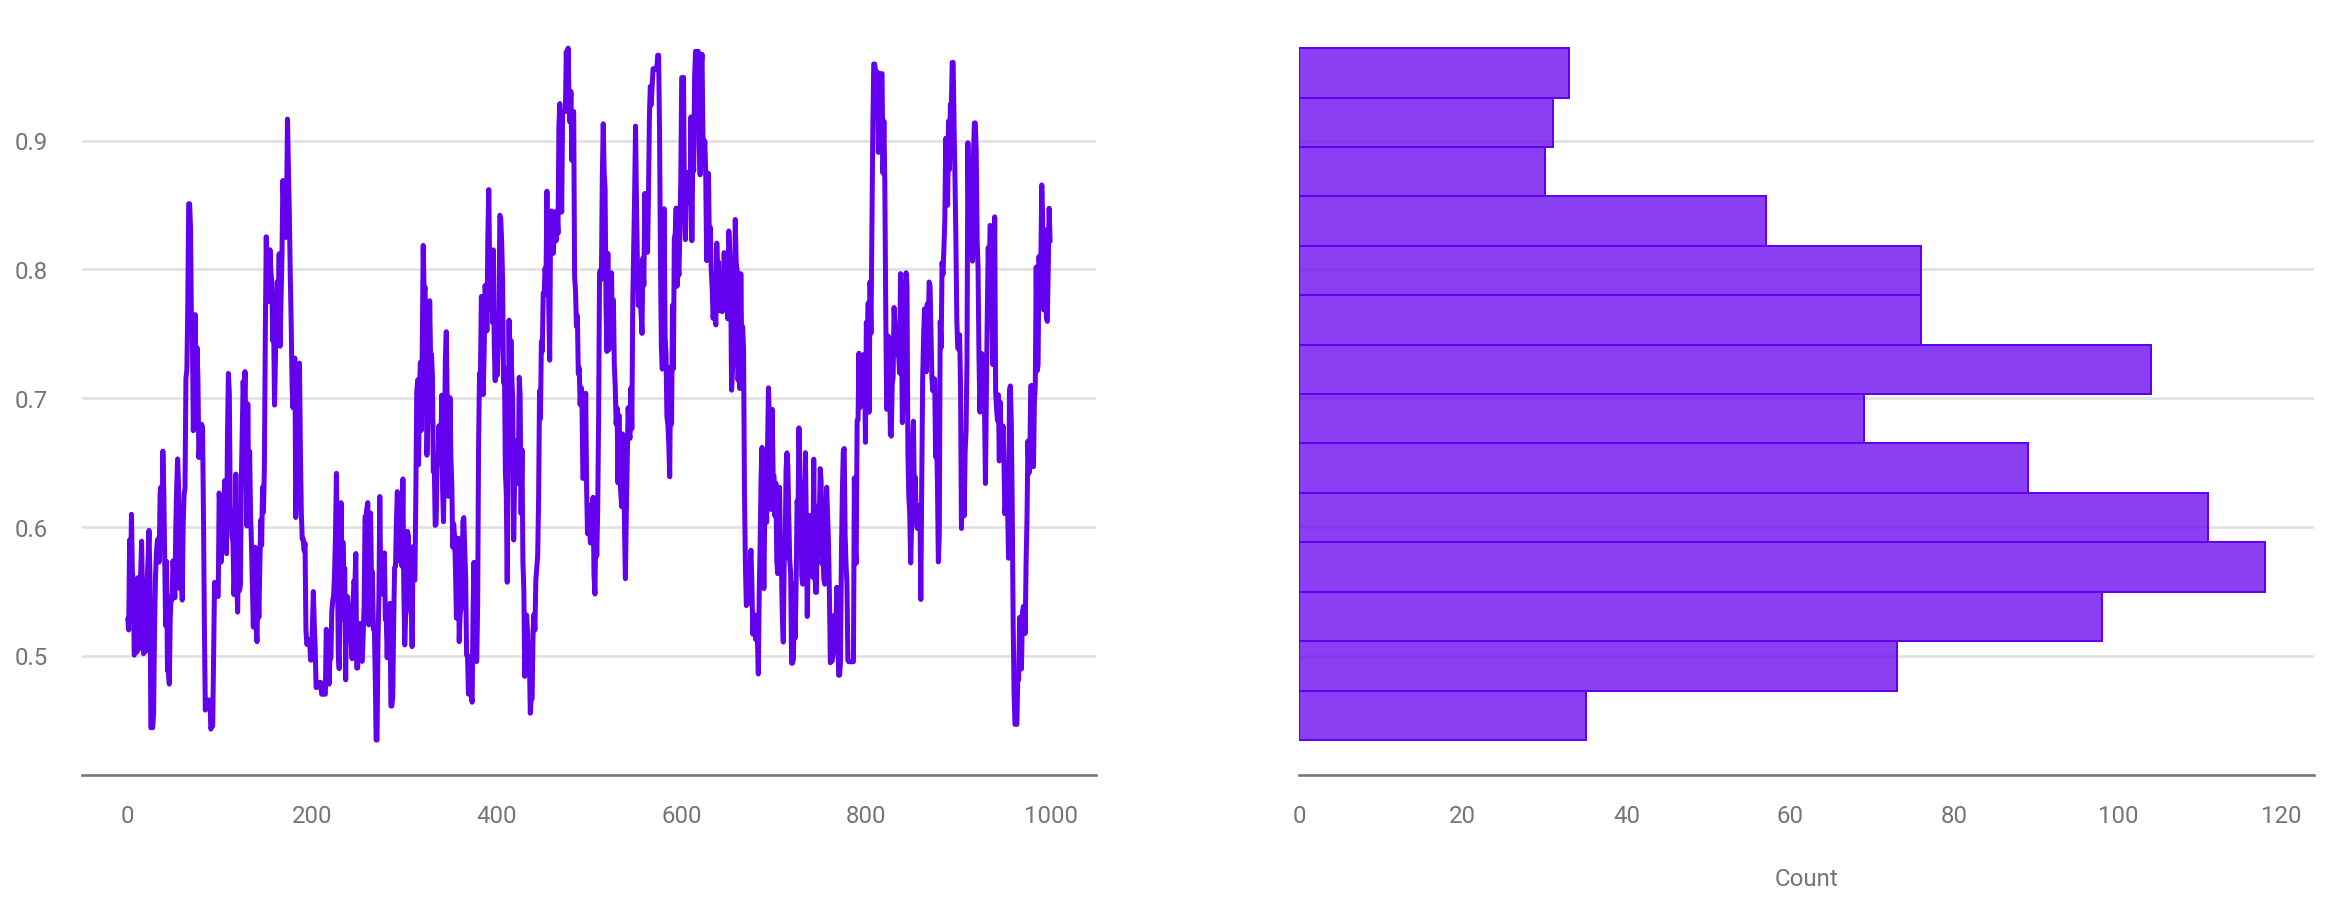

In [135]:
_, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(20, 7))
sns.lineplot(y=trace["theta"], x=np.arange(0, trace["theta"].shape[0]), ax=ax1)
sns.histplot(y=trace["theta"], ax=ax2);

In [136]:
az.summary(trace, kind="stats")

,mean,sd,hdi_3%,hdi_97%
theta,0.671,0.131,0.465,0.923


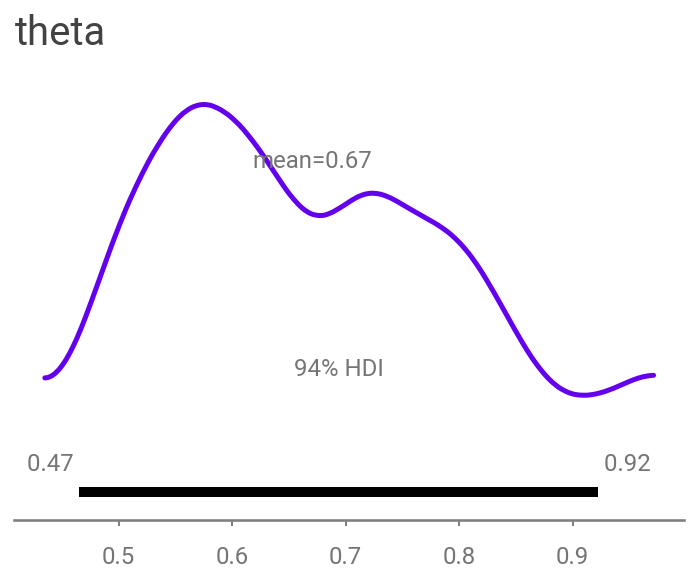

In [138]:
az.plot_posterior(trace);

Real algorithms would calculate efficiencies on the log scale to be more efficient.
Also `theta_candidate` is a parameter of the algorithm,
not the Bayesian model.

**Highest density interval (HDI)**
is the shortest interval containing some percentage of the values.

## Automated inference, not automated model building

**Probabalistic Programing Languages (PPL)**
have universal inference engines—which
are not truly universal.

In [8]:
# Model in PyMC3
with pm.Model() as model:
    # Specify the prior
    theta = pm.Beta("theta", alpha=1, beta=1)

    # Specify the likelihood
    y_observed = pm.Binomial("y_observed", n=1, p=theta, observed=Y)

    # Sample from posterior
    inference_data = pm.sample(1_000, return_inferencedata=True)

# pm.model_to_graphviz(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


It can evaluate the log-probability
of the random variables to get the posterior distribution.

In [11]:
pred_dists = (
    pm.sample_prior_predictive(samples=1_000, model=model)["y_observed"],
    pm.sample_posterior_predictive(inference_data, 1_000, model)["y_observed"],
)

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


![Bayesian distributions](images/chapter_1/Bayesian_quartet_distributions.png)


The posterior predictive distributions take into acccount
uncertainties about the estimates.

## Options to quantify your prior information

### Conjugate priors

A prior is conjugate to a likelihood
if the posterior belongs to the same family of distributions as the prior.

The conjugate prior for the binomial distribution
is the Beta distribution.


### Objective priors

**Objective priors**
are systematic ways of generating priors
that have the least possible influence
on an analysis.

**Jeffrey's Prior (JP)**
is invariant under reparametrization.
ie. You want a prior for Binomal,
you can choose parameter fo $\theta$,
or prior for odds of success, $\kappa = \frac{\theta}{1 - \theta}$.
JP guarantees that either will result in the same $\kappa$ estimation.

For 1D

$$
p(\theta) \propto \sqrt{I(\theta)}
$$

where $I(\theta)$ is the expected Fisher information:

$$
p(\theta) \propto \theta^{-0.5} (1-\theta)^{-0.5}
$$

### Maximum entropy priors

Can pick prior with highest entropy.
If we are indifferent about plausible values,
then this is Uniform distribution over the range of plausible values.
You can add constraints to it,
such as must be between these values,
must have a certain mean,
certain values must have certain probabilities,
etc
It basically tried to pick the widest distribution
given the contraints.

| Constraint                                     | Support             | Distribution                        |
| ---------------------------------------------- | ------------------- | ----------------------------------- |
| None                                           | None                | Uniform                             |
| Positive mean                                  | $[0, \infty)$       | Exponential                         |
| Absolute deviation to the mean                 | $(-\infty, \infty)$ | Laplace                             |
| A given mean and variance                      | $(-\infty, \infty)$ | Normal                              |
| A given mean and variance                      | $[-\pi, \pi]$       | Von Mises                           |
| Only two unordered outcomes with constant mean | None                | Binomial, or Poisson if rare events |


## Weakly informative priors and regularization priors

Using context—such
as whether value should be positive,
or plausible range—is
generally better.

## Using prior preditvie distribution to asess priors

Sample from priors to see output of model before data
and judge whether results generated by priors are plausible.